**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)
from tqdm import tqdm

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

In [3]:
PATH = Path('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/')
list(PATH.iterdir())

[WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/data'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/info.txt'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/models'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/orig_data.zip'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/resnet34_weights.h5.h5'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/Submission-1-Code.py'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/submission_1.csv'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/submission_2.csv'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/submission_3 - Copy.csv'),
 WindowsPath('X:/Flipkart GRID - Ob

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [ ]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

In [ ]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

In [ ]:
trn_j[ANNOTATIONS][:2]

In [ ]:
trn_j[CATEGORIES][:4]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [ ]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [ ]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

In [4]:
JPEGS = 'training_images_resized'

In [5]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/training_images_resized/1457419537031DSC_0002.png'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/training_images_resized/14581478747652.png'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/training_images_resized/14581479921661.png'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/training_images_resized/14581480028821A.png'),
 WindowsPath('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/training_images_resized/14581480050692.png')]

Each image has a unique ID.

In [7]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# trn_anno = collections.defaultdict(lambda:[])
# for o in trn_j[ANNOTATIONS]:
#     if not o['ignore']:
#         bb = o[BBOX]
#         bb = hw_bb(bb)
#         trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
# len(trn_anno)

In [8]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [9]:
im = open_image(IMG_PATH/'1473501993177IMG_20160910_145542.png')

Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [10]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [11]:
show_img(im)

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [12]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [13]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [14]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [16]:
ax = show_img(im)
# b = bb_hw(im0_a[0])
# draw_rect(ax, b)
# draw_text(ax, b[:2], cats[im0_a[1]])

In [17]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [18]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

In [21]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

## Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [22]:
BB_CSV = PATH/'training_with_space_delim.csv'

In [23]:
# bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
# bbs = [' '.join(str(p) for p in o) for o in bb]
temp = pd.read_csv(PATH/'training.csv')
list_of_labels = []
for i, row in tqdm(enumerate(temp.values)):
    tup = (int(row[1]*224/640), int(row[2]*224/640), int(row[3]*224/480), int(row[4]*224/480))
    list_of_labels.append(tup)
bbs = [' '.join(str(p) for p in o) for o in list_of_labels]

df = pd.DataFrame({'fn':[ o for o in temp.image_name.values], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

14000it [00:00, 609592.91it/s]


In [24]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 'JPEG_20160706_121146_1000145715002.png,40 173 66 151\n',
 'JPEG_20161119_174038_1000690577600.png,8 159 28 190\n',
 '147444927651111470309333776-Roadster-Men-Casual-Shoes-3041470309333487-1.png,12 210 6 219\n',
 '147772332675720161028_161611.png,9 210 75 179\n']

In [25]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [26]:
# augs = [RandomFlip(), 
#         RandomRotate(30),
#         RandomLighting(0.1,0.1)]
augs = []

In [27]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]
2.64
[0. 0. 1. 1.]


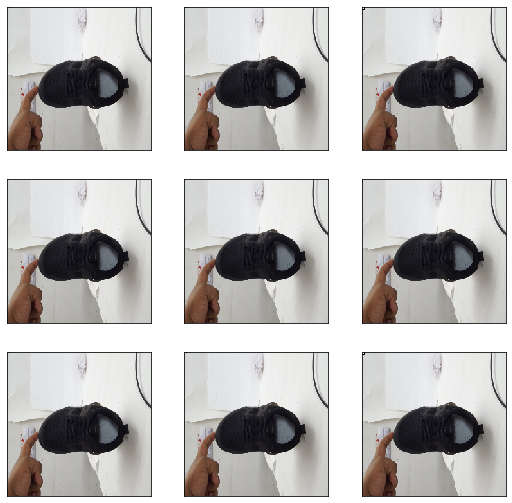

In [36]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
#     ima=md.val_ds.denorm(to_np(x))[idx]
    print(np.max(to_np(x)))
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [29]:
# augs = [RandomFlip(tfm_y=TfmType.COORD),
#         RandomRotate(30, tfm_y=TfmType.COORD),
#         RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [30]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]


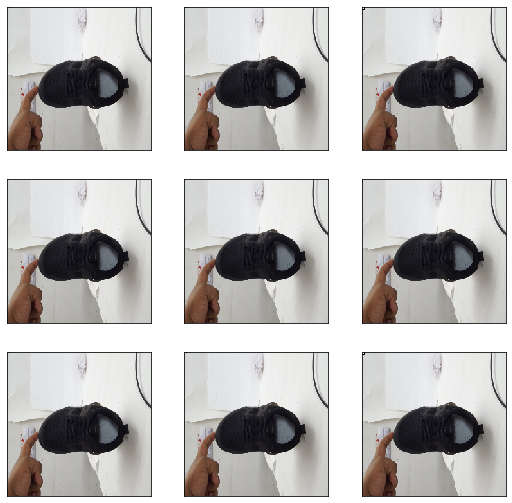

In [31]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [ ]:
tfm_y = TfmType.NO
# augs = [RandomFlip(tfm_y=tfm_y),
#         RandomRotate(3, p=0.5, tfm_y=tfm_y),
#         RandomLighting(0.05,0.05, tfm_y=tfm_y)]
augs = []

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [ ]:
512*7*7

In [ ]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [ ]:
learn.save(PATH/'resnet34_weights.h5')

In [ ]:
!dir

In [ ]:
learn.summary()

In [ ]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [ ]:
lr = 2e-3

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(lrs, 1, cycle_len=2)

In [ ]:
learn.save('reg4')

In [ ]:
learn.load('reg4')

In [ ]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

In [ ]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [ ]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [ ]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [ ]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [ ]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [ ]:
val_ds2[0][1]

We can replace the dataloaders' datasets with these new ones.

In [ ]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [ ]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

In [ ]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [ ]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [ ]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=1e-2

In [ ]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

In [ ]:
learn.save('reg1_0')

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrs = np.array([lr/100, lr/10, lr])

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

In [ ]:
learn.save('reg1_1')

In [ ]:
learn.load('reg1_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

In [ ]:
learn.save('reg1')

In [ ]:
learn.load('reg1')

In [ ]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [ ]:
from scipy.special import expit

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## End